## Text Analysis
1. [Review Statistics](#statistics) <br>
2. [Part of Speech (POS) Tagging](#pos_tagging) <br>
3. [N-gram language generation](#n_gram) <br>
4. [Latent Semantic Analysis (LSA)](#lsa) <br>
   

In [1]:
# section importing the data
from bs4 import BeautifulSoup
from urllib.request import urlopen
import time
import re
import requests
from requests.exceptions import HTTPError
import urllib
import csv
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np

In [2]:
def isEnglish(s): # remove non-english reviews
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:    
        return True
def convert_to_lowercase(inputstr):
    return inputstr.lower()
def removePunctuation(inputstr):
    return re.sub(r'[^\w\s]', '', inputstr)
def removeStopwords(inputstr, sw):
    word_tokens = nltk.word_tokenize(inputstr)
    filtered = [word for word in word_tokens if word not in sw]
    s = " "
    return s.join(filtered)
def lemmatize(inputstr, lemmatizer):
    word_tokens = nltk.word_tokenize(inputstr)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_tokens]
    return " ".join(lemmatized)
def cleanstr(inputstr, sw, lemmatizer):
    return lemmatize(removeStopwords(removePunctuation(convert_to_lowercase(inputstr)), sw), lemmatizer)

In [3]:
app_ids = ["529479190", "1053012308", "1160056295", "1150318642", "656176278", "1009134067", 
           "1330123889", "1094930513", "1055502792"] # target apps in iOS store
review = dict() # resulting dictionary
lemmatizer = WordNetLemmatizer() 
sw = stopwords.words('english')
for app_id in app_ids: 
    for page in range(1, 21): # get the first 20 pages of review for each game
        url = "https://itunes.apple.com/us/rss/customerreviews/page=" + str(page) \
              + "/id=" + app_id + "/sortby=mostrecent/xml?urlDesc=/customerreviews/id=" + app_id + "/xml"
        response= requests.get(url)
        soup = BeautifulSoup(response.content,"html.parser")
        matches = soup.findAll("entry") # find the matching items
        # obtain a list of items: app_id, review title, review time, review rating and review content for each review
        for m in matches: 
            review_title = m.find("title").text # obtain the review title
            review_content = m.find("content").text # obtain the review content
            # collect only the English reviews
            if isEnglish(review_title) == True and isEnglish(review_content) == True:
                review_time = m.find("updated").text[:10] # obtain the review time
                review_rating = m.find("im:rating").text # obtain the review rating
                # put the list of items into dictionary, identified by key (review_id)
                review[m.find("id").text] = [app_id, cleanstr(review_title, sw, lemmatizer), review_time, 
                                             review_rating, cleanstr(review_content, sw, lemmatizer)]      

<a id='statistics'></a>
#### 1. Review Statistics

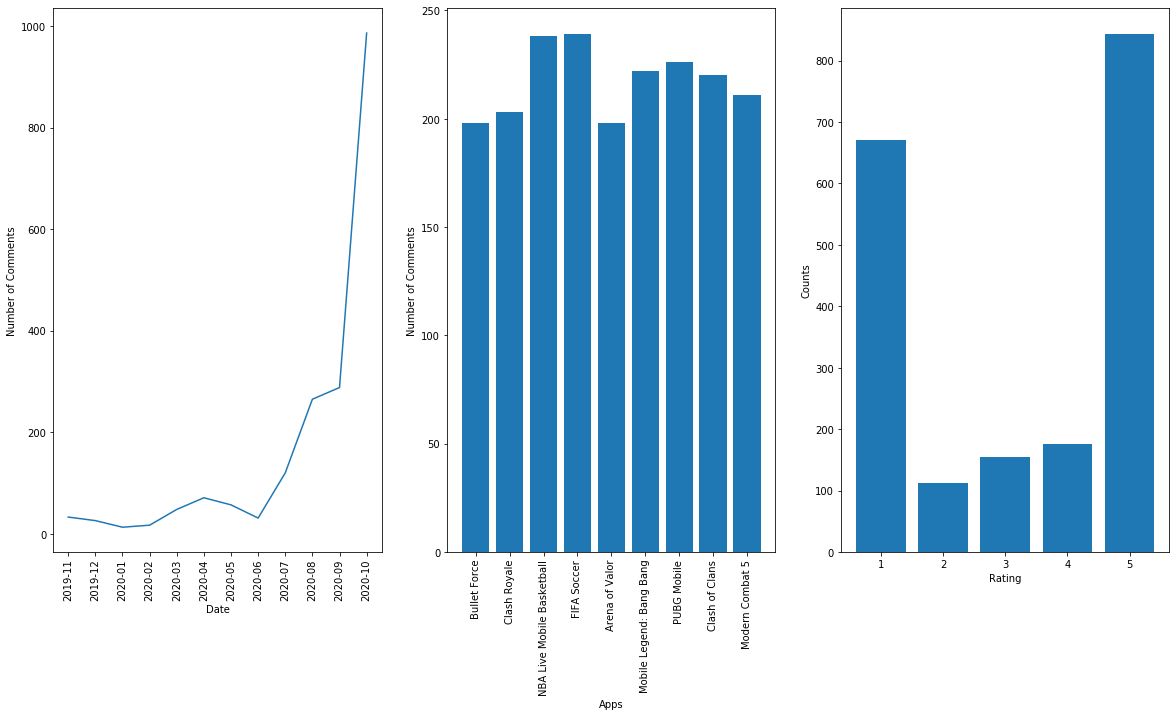

In [141]:
import matplotlib.pyplot as plt
from datetime import datetime as dt

df_reviews = pd.DataFrame.from_dict(review, orient = 'index')
df_reviews.columns = ['app_id', 'title', 'time', 'rating', 'content']
df_reviews['time_month'] = pd.to_datetime(df_reviews['time'], format = '%Y-%m-%d').dt.strftime("%Y-%m")
dates_df = df_reviews[['time_month','rating']].groupby(by = 'time_month').count()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(dates_df.index, dates_df['rating'])
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation = 90)
apps_df = df_reviews[['rating', 'app_id']].groupby(by = 'app_id').count()
app_dict = {
    529479190: 'Clash of Clans', 1053012308: 'Clash Royale', 1160056295: 'Mobile Legend: Bang Bang', 
    1150318642: 'Arena of Valor', 656176278: 'Modern Combat 5', 1009134067: 'Bullet Force', 
    1330123889: 'PUBG Mobile', 1094930513: 'FIFA Soccer', 1055502792: 'NBA Live Mobile Basketball'
}
apps_df['app_names'] = [val for ind in apps_df.index for key, val in app_dict.items() if int(ind )== key]
for key, val in app_dict.items():
    apps_df.loc[key, 'app_names'] = val
plt.subplot(1,3,2)
plt.bar(apps_df['app_names'], apps_df['rating'])
plt.xlabel('Apps')
plt.ylabel('Number of Comments')
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
ratings_df = df_reviews[['rating', 'app_id']].groupby(by = 'rating').count()
plt.bar(ratings_df.index, ratings_df['app_id'])
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show()

More reviews are available for dates closer to the date when the data is collected. It makes sense because only the first 20 pages of reviews are scrapped and loaded. A relatively small number of reviews at earlier dates. I would expect that the activity level (number of reviews) would stay the same over time. An gradually increasing number of review is probably due to the way Apple list reviews. The reviews are probably organized by time window but not exact dates (this is a guess). <br>
The number of reviews from each game mentioned are the similar. Most reviews are leaning towards extremum (1 or 5). This phenomena can be explained by people's motive to leave comments. People feeling ok about the game are less likely to leave comments, whereas peoeple who have strong feelings on the game are more likely to leave comments. 

<a id='pos_tagging'></a>
#### 2. Part of Speech (POS) Tagging
In this section, the reviews are all combined into one. The words from different reviews are tagged with word-category (noun, verb, adjective, adverb, etc.). Then a brief analysis is done on the POS tagging. 

In [10]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
# nltk.download('brown')
# nltk.download('averaged_perceptron_tagger')

In [38]:
def get_target_word(word_tokens): 
    """ 
    This function converts past tense/past principle to simple present tense
    input: tokenized words
    output: stemmed words
    """ 
    p_stemmer = PorterStemmer()
    w_lemma = WordNetLemmatizer()
    p_stemmed = [p_stemmer.stem(word) for word in word_tokens]
    tags = nltk.pos_tag(p_stemmed)
    tot_words = len(tags)
    for i in range(tot_words):
        if tags[i][1].startswith('V'):
            p_stemmed[i] = w_lemma.lemmatize(p_stemmed[i], 'v')
    return p_stemmed
def tagging_speech(document_list): # part of speech tagging
    document = " ".join(document_list) # join the reviews into one
    tokenizer = RegexpTokenizer(r'\w+') # define tokenizer
    tokens = tokenizer.tokenize(document) # token
    stemmed_tokens = get_target_word(tokens) # stemming and process verbs
    tags = nltk.pos_tag(stemmed_tokens)
    return tags

In [47]:
tags = tagging_speech(df_reviews['content'])
print('total words in all review contents:', len(tags))
tag_fd = nltk.FreqDist(tag for (word, tag) in tags)
print(tag_fd.most_common())

total words in all review contents: 24280
[('NN', 12385), ('JJ', 4437), ('VBP', 1690), ('RB', 1269), ('VB', 1139), ('CD', 871), ('IN', 534), ('NNS', 495), ('VBD', 289), ('MD', 217), ('JJS', 150), ('VBZ', 125), ('JJR', 114), ('FW', 96), ('VBN', 94), ('RBR', 91), ('DT', 58), ('NNP', 37), ('RP', 37), ('WP', 23), ('RBS', 21), ('CC', 21), ('VBG', 20), ('TO', 14), ('$', 14), ('WDT', 11), ('PRP', 8), ('WRB', 6), ('PRP$', 5), ('EX', 3), ('WP$', 2), ('UH', 2), ('PDT', 1), ('``', 1)]


In [50]:
vbd_list = [word for (word, tag) in tags  if tag == 'VBD']
vbd_list[:5]

['stroke', 'incred', 'put', 'abus', 'sheld']

Observe that the number of total words in all reviews (1963 reviews) is 24280. Through an attempt to assign word categories to the words, a primary result of the POS tagging can be shown below. Given the total number of reviews, the word of review contents can each be tagged with word categories. The following table presents the occurrences of words in each word tag who has occurrences higher than 500. 

| Tag | Meaning | Occurrences |
| --- | --- | --- | 
| NN | noun | 12385 |
| JJ | adjective | 4437 |
| VBP | verb (present, non-singular) | 1690 |
| RB | adverb | 1269 | 
| VB | verb | 1139 | 
| CD | cardinal digit | 871 |
| IN | preposition/subordinating conjunction | 534 |


----------
1. Since the many stopwords have been removed from the review content, so most words in the reviews are the "essential" words, mostly noun, verb, adjective and adverbs. 
2. The pie chart illustrated below shows the percentage by word category in the cleaned (and with stopword removed) review content. In the verb category, verb of different tenses are also included. 
3. Verbs in past tense and past principles also exists (although in relatively small number) in POS tagging even after applying WordNetLemmatizer() for verb. By examining some of the vbd (verb with past tense), we discover that thare are mixed reasons for their existence. For example, the word "stroke" itself can be a verb (stroke - stroked - stroked), or a past tense of strike.


----------


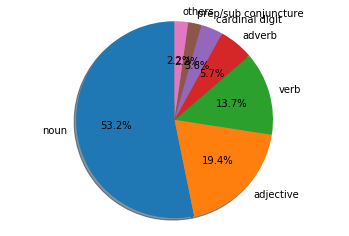

In [60]:
import matplotlib.pyplot as plt
tag_names = ['noun', 'adjective', 'verb', 'adverb', 'cardinal digit', 'prep/sub conjuncture', 'others']
tag_num = [12385+495+37, 4437+150+114, 1690+1139+289+125+94, 1269+91+21, 871, 534, 
           24280-12385-495-37- 4437-150-114 -1690-1139-289-125-94 -1269-91-21 -871 -534]
plt.pie(tag_num, labels = tag_names, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.show()

Investigate the top occurred words by category. 

In [88]:
noun_type = ['NN', 'NNS', 'NNP']
verb_type = ['VBP', 'VB', 'VBD', 'VBZ', 'VBN']
adj_type = ['JJ', 'JJS', 'JJR']
adv_type = ['RB', 'RBS', 'RBR']
def count_word_cat(word_tag, category):
    word_list = [word for (word, tag) in word_tag if tag in category]
    count_dict = dict()
    for word in set(word_list):
        count_dict[word] = word_list.count(word)
    return count_dict

In [91]:
# top 10 by each category
# did not write a function b/c function runs very slow
noun_df = pd.DataFrame.from_dict(count_word_cat(tags, noun_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
noun_df.reset_index(inplace = True)
noun_df.columns = ['noun', 'noun_count']
verb_df = pd.DataFrame.from_dict(count_word_cat(tags, verb_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
verb_df.reset_index(inplace = True)
verb_df.columns = ['verb', 'verb_count']
adj_df = pd.DataFrame.from_dict(count_word_cat(tags, adj_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
adj_df.reset_index(inplace = True)
adj_df.columns = ['adj', 'adj_count']
adv_df = pd.DataFrame.from_dict(count_word_cat(tags, adv_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
adv_df.reset_index(inplace = True)
adv_df.columns = ['adv', 'adv_count']

In [97]:
top_10 = pd.concat([noun_df.iloc[:10,:], verb_df.iloc[:10,:], adj_df.iloc[:10,:], adv_df.iloc[:10,:]], axis = 1)
top_10

,noun,noun_count,verb,verb_count,adj,adj_count,adv,adv_count
0,game,1603,get,286,good,241,back,115
1,script,421,make,245,updat,158,even,98
2,play,362,play,138,great,143,ever,79
3,player,224,go,123,new,123,also,73
4,time,155,love,102,best,84,better,67
5,pleas,138,want,99,u,73,still,63
6,team,128,say,99,much,70,alway,57
7,fun,126,take,82,bad,58,never,54
8,match,95,need,73,graphic,54,well,31
9,money,92,give,70,pleas,46,much,31


Through the POS tagging task, it is natural to realize that noun is the most frequently occurred word category amongst all reviews. By reviewing some top nouns, we may see what do players of competitive games concern the most. Aside from the top word game, the second top word is script, which could probably refer to the game script itself or players' script manipulation. <br>
Some adjective also helps to understand how does the people view the game. <br>

<a id='n_gram'></a>
#### 3. N-gram language generation
Then we could use n-gram by frequency to get to know what are most players saying out of their words. Since nouns are consists of most of the review word category, the following analysis will focus on nouns. 

In [168]:
def get_bglist(document_list):
    bglist = list()
    for document in document_list:
        document = document.split(" ")
        for i in range(len(document)-1):
            bglist.append((document[i], document[i+1]))
    bigram = dict((x,bglist.count(x)) for x in sorted(set(bglist), key=bglist.index))
    return bigram
def createsentence(seedword, len_sent = 5):
    # sort the dictionary by bigram occurrences
    sorteddict = {k: v for k, v in sorted(bigram.items(), key=lambda item: item[1], reverse = True)}
    def next_word(wordsss): 
        # obtain all bigrams containing the target word in the first position
        # get the bigram with the highest frequency, and select the next word
        next_word = [word for word in sorteddict.keys() if wordsss in word[0]][0][1]
        return next_word
    final_str = seedword
    for i in range(len_sent):
        final_str = " ".join([final_str, next_word(seedword)])
        seedword = next_word(seedword)
    return final_str

In [150]:
bigram = get_bglist(df_reviews['content'])

In [172]:
for word in noun_df.iloc[:10,0]:
    print(createsentence(word, 5))

game ever time try get game
script scripted scripted scripted scripted scripted
play game ever time try get
player like game ever time try
time try get game ever time
pleas fix game ever time try
team always get game ever time
fun game ever time try get
match making game ever time try
money game ever time try get


Review the generated language based on the top 10 hitted nouns. Many sentence would end up with word like "game", "try", and "get". This is probably because "game" is the top hitted word among the nouns. So the generated sentence would very likely end up on "game". A way to improve this is to try trigram instead. 

In [161]:
def get_tglist(document_list):
    tglist = list()
    for document in document_list:
        document = document.split(" ")
        for i in range(len(document)-2):
            tglist.append((document[i], document[i+1], document[i+2]))
    trigram = dict((x,tglist.count(x)) for x in sorted(set(tglist), key=tglist.index))
    return trigram
def createsentence_trigram(seedword, len_sent = 6):
    # sort the dictionary by bigram occurrences
    sorteddict = {k: v for k, v in sorted(trigram.items(), key=lambda item: item[1], reverse = True)}
    def next_words(wordsss): 
        # obtain all bigrams containing the target word in the first position
        # get the bigram with the highest frequency, and select the next word
        next_word1 = [word for word in sorteddict.keys() if wordsss in word[0]][0][1]
        next_word2 = [word for word in sorteddict.keys() if wordsss in word[0]][0][2]
        return next_word1, next_word2
    final_str = seedword
    for i in range(round(len_sent/2)):
        word1, word2 = next_words(seedword)
        final_str = " ".join([final_str, word1, word2])
        seedword = word2
    return final_str

In [157]:
trigram = get_tglist(df_reviews['content'])

In [256]:
for word in noun_df.iloc[:10,0]:
    print(createsentence_trigram(word, 6))

game ever played game year playing game
script scripted scripted scripted scripted scripted scripted
play long time try play long time
player bot match making system bad need
time try play long time try play
pleas bring back global chat much fun
team need developed old version open play
fun competitive game ever played game year
match making system bad need balance hero
money make game ever played game year


Trigram returns better results in language generation. It suggests some thoughts of players, including long time of play, fun from competition. Some concerns also reveals, including the need for global chat improvement, the need for team system / match system improvement, etc. Notice that script is not generating sensible sentence here. Look into script in the later chunk. 

In [166]:
sorteddict1 = {k: v for k, v in sorted(trigram.items(), key=lambda item: item[1], reverse = True)}
script_trigram = [word for word in sorteddict1.keys() if 'script' in word[0]]
print(script_trigram)
toward_trigram = [word for word in sorteddict1.keys() if 'toward' in word[0]]
print(toward_trigram)

[('scripted', 'scripted', 'scripted'), ('scripted', 'geared', 'toward')]
[('towards', 'retard', 'like'), ('toward', 'making', 'pay'), ('towards', 'paytowin', 'player'), ('towards', 'bottom', 'list')]


By looking into script, we may observe that 'script' carries bad emotions if we select the next available trigram alternative, either suggesting bad gameplay experience or bad monetary experience. <br>

#### 3. N-gram language generation (TF-IDF Matrix)

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer
doc = list(df_reviews['content'])
tfidf_vectorizer = TfidfVectorizer(use_idf = False) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(doc)
df = pd.DataFrame(tfidf_vectorizer_vectors.T.todense(), index = tfidf_vectorizer.get_feature_names(), columns = df_reviews.index)

In [242]:
most_relavant_val = df.idxmax()
most_relavant_val[:10]

6574356968    amazing
6573998856    5000000
6573400182      level
6573394674       clan
6573169297        yes
6572967526        fun
6570957159       clan
6570344378      yummy
6570199356       clan
6570144465       good
dtype: object

The above list shows the most relevant word in each of the 10 documents (identified by review id). 

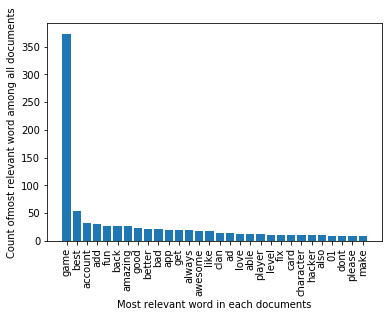

In [254]:
relevant_list = [(word,  list(most_relavant_val).count(word)) for word in set(list(most_relavant_val))] 
df_relevant = pd.DataFrame()
df_relevant['r_word'] = [item[0] for item in relevant_list]
df_relevant['count'] = [item[1] for item in relevant_list]
df_relevant.sort_values(by = 'count', inplace = True, ascending = False)
plt.bar(df_relevant['r_word'][:30], df_relevant['count'][:30])
plt.xlabel('Most relevant word in each documents')
plt.ylabel('Count ofmost relevant word among all documents')
plt.xticks(rotation = 90)
plt.show()

The plot above tells about the most relevant word (marked by high term frequency in single document but low document frequency in whole document collection). Among over 1,900 reviews, the most relevant word of over 350 of them is game. Then the count quickly drops as high dfidf accounts for low document frequency as well. Still, the most relevant words could be provide insights on how players view the games. 

In [259]:
print(sum(df_relevant['count'][:30])/len(df_reviews.index))
for word in df_relevant['r_word'][:15]:
    print(createsentence_trigram(word, 5))

0.45728900255754473
game ever played game year
best game ever time try
account back got updating content
add global chat much fun
fun competitive game ever played
back global chat much fun
amazing game playing long time
good game really good game
better anti cheat customer service
bad need global chat back
app cant get old account
get old account back got
always tell clan war 2
awesome playing like game lot
like game lot money game


The first 15 of the most relevant word accounts for the most relevant word for around 46% of the reviews (documents). Then we may discuss how the most relevant word can be used to generate the word sequence. 7 out of 15 (over half) of the generated language is associated with good sentimen. 3 out of 15 is about account issues (old account and update). 3 out of 15 is about global chat (need it or add it back). 1 is about anti-cheating issues. The generated langauges suggests three issues that the players concern the most, two of which could be equally important. Game developers should look into these features: accout/update issues, global chat function and anti-cheating customer service. 

<a id='lsa'></a>
#### 4. Latent Semantic Analysis

In [103]:
# tokenize 
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def preprocess_data(documents_list):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = PorterStemmer()
    txt = []
    for raw in documents_list:
        tokens = tokenizer.tokenize(raw)
        words = [word for word in tokens]
        stemmed_tokens = [stemmer.stem(word) for word in words]
        txt.append(stemmed_tokens)
    return txt
def prepare_corpus(cleaned_documents_list):
    dictionary = corpora.Dictionary(cleaned_documents_list)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_documents_list]
    return dictionary, doc_term_matrix
def create_gensim_lsa_model(clean_documents_list,number_of_topics,words):
    dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary) 
    return lsamodel
def compute_coherence_values(term_dictionary, doc_term_matrix, cleaned_documents_list, start, stop, step):
    coherence_values = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = term_dictionary) 
        coh_model = CoherenceModel(model=model, texts=cleaned_documents_list, dictionary=term_dictionary, coherence='c_v')
        coherence_values.append(coh_model.get_coherence())
    return coherence_values
def plot_graph(coherence_values,start, stop, step):
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

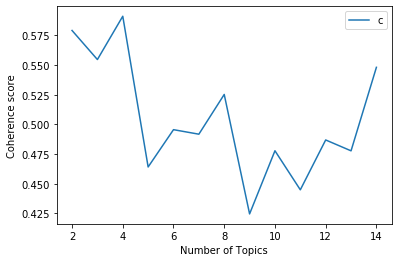

In [104]:
start,stop,step = 2, 15, 1
document_list = df_reviews['content']
clean_documents_list = preprocess_data(document_list)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

In [105]:
number_of_topics = 4 # chosen by graph, the graph may change after re-run
words=10
model=create_gensim_lsa_model(clean_documents_list,number_of_topics,words)
print(model.print_topics(num_topics=number_of_topics, num_words=words))

[(0, '-1.000*"script" + -0.000*"game" + -0.000*"rig" + -0.000*"play" + -0.000*"like" + -0.000*"make" + -0.000*"win" + -0.000*"trash" + -0.000*"know" + -0.000*"ea"'), (1, '0.824*"game" + 0.271*"play" + 0.154*"get" + 0.136*"like" + 0.116*"player" + 0.099*"make" + 0.082*"good" + 0.082*"love" + 0.078*"would" + 0.070*"team"'), (2, '-0.486*"game" + 0.465*"get" + 0.399*"play" + 0.211*"like" + 0.200*"would" + 0.174*"player" + 0.171*"match" + 0.152*"make" + 0.109*"pleas" + 0.100*"team"'), (3, '-0.480*"play" + 0.458*"like" + 0.327*"make" + 0.306*"player" + -0.199*"get" + 0.186*"pleas" + 0.124*"u" + 0.123*"better" + 0.109*"also" + 0.094*"updat"')]


The number of topics is calculated to be 4 in this case. Observe the four topics. <br>
The first topic is about script. As discussed earlier, "script" is one of the most frequently written noun among all reviews. The sentence generated by the Isa model does not give a strong implication of what do "script" associate with. As discussed in previous n-gram language generation, "script" (if not choosing the top hit) could be related to bad gameplay or bad monetary experience. <br>
The second topic is about gameplay. It expresses good emotion about competitive games and imply the willingness to team <br>
The third topic is also about gameplay enjoyment, but it expresses the urge from players to encourage teaming. This indicates that the players may have mixed impression on team matching condition <br>
The fourth topic is about gameplay enjoyment and the need for update. <br>
Through LSA, we see some interesting topics that players discuss behind the reviews. 